# Convolutional Autoencoder

## 1. Import Libraries & Load Data
- Imports TensorFlow and NumPy, then loads your X_train_normal.npy 
- We need to get the Normal spectrograms into memory to train the model. It also plots one image to confirm the data isn't corrupted (it should look like a heatmap, not static noise).

Data loaded successfully :D
Shape: (3009, 128, 128, 1)
Min value: 0.00, Max value: 1.00


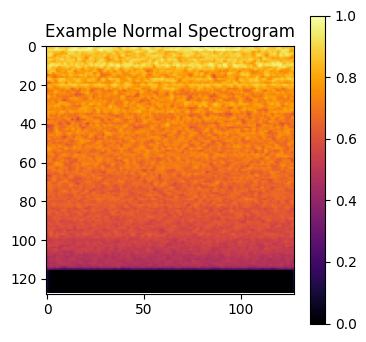

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, Model

# 1. Load the dataset X_train_normal.npy
# Current Folder: /app/src
data_path = '../data/processed/X_train_normal.npy'

try:
    X_train = np.load(data_path)
    print(f"Data loaded successfully :D")
    print(f"Shape: {X_train.shape}")  # 128
except FileNotFoundError:
    print(f"Error: Could not find {data_path} :(")

# 2. Check the data range (Should be 0 to 1)
print(f"Min value: {X_train.min():.2f}, Max value: {X_train.max():.2f}")

# 3. Visualize a random sample
plt.figure(figsize=(4, 4))
plt.imshow(X_train[0].reshape(128, 128), cmap='inferno')
plt.title("Example Normal Spectrogram")
plt.colorbar()
plt.show()

## 2. Build the Convolutional Autoencoder
We will use a standard architecture for 128x128 images.
- Encoder: Compresses the image (128x128 → 64x64 → 32x32 → 16x16).
- Decoder: Expands it back to 128x128.

In [5]:
def build_autoencoder(input_shape):
    
    # --- ENCODER ---
    input_img = layers.Input(shape=input_shape)
    
    # Compress 128 -> 64
    x = layers.Conv2D(32, (3, 3), strides=2, padding='same', activation='relu')(input_img)
    # 64 -> 32
    x = layers.Conv2D(64, (3, 3), strides=2, padding='same', activation='relu')(x)
    # 32 -> 16 :Latent Space
    encoded = layers.Conv2D(128, (3, 3), strides=2, padding='same', activation='relu')(x)

    # --- DECODER ---
    # Expand 16 -> 32
    x = layers.Conv2DTranspose(128, (3, 3), strides=2, padding='same', activation='relu')(encoded)
    # 32 -> 64
    x = layers.Conv2DTranspose(64, (3, 3), strides=2, padding='same', activation='relu')(x)
    # 64 -> 128
    x = layers.Conv2DTranspose(32, (3, 3), strides=2, padding='same', activation='relu')(x)
    
    # Final Output (1 channel, sigmoid activation for 0-1 range)
    decoded = layers.Conv2D(1, (3, 3), padding='same', activation='sigmoid')(x)

    # Combine into a Model
    autoencoder = models.Model(input_img, decoded)
    return autoencoder

# Initialize model
INPUT_SHAPE = (128, 128, 1)
model = build_autoencoder(INPUT_SHAPE)

# Compile the model
# adam is the standard optimizer
# mse'(Mean Squared Error) measures pixel-by-pixel difference
model.compile(optimizer='adam', loss='mse')

model.summary()

2025-12-27 11:03:46.470277: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 32, 32, 128)    │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 64, 64, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 128, 128, 32)   │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 1)    │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 332,801 (1.27 MB)

 Trainable params: 332,801 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

## 3. Train the Model
- Input: X_train (Normal sound)
- Target: X_train (We want it to reproduce the same sound)

In [6]:
# Train
history = model.fit(
    X_train, X_train,
    epochs=30, # How many times to loop through the data (20-50 -> good)
    batch_size=32, # How many images to process at once
    shuffle=True,
    validation_split=0.1,  # Used 10% of data to check validation loss
    verbose=1
)

# Save the trained model
#  model.save("data/processed/autoencoder_model.keras")
model.save("../data/processed/autoencoder_model.h5")
print("Model saved to data/processed/autoencoder_model.h5 :D")

Epoch 1/30


2025-12-27 11:10:41.527810: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 177471488 exceeds 10% of free system memory.
2025-12-27 11:10:41.692813: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 177471488 exceeds 10% of free system memory.
2025-12-27 11:10:43.284312: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 67108864 exceeds 10% of free system memory.
2025-12-27 11:10:43.375240: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 67108864 exceeds 10% of free system memory.


 1/85 ━━━━━━━━━━━━━━━━━━━━ 2:50 2s/step - loss: 0.0608

2025-12-27 11:10:43.897843: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 67108864 exceeds 10% of free system memory.


85/85 ━━━━━━━━━━━━━━━━━━━━ 50s 572ms/step - loss: 0.0307 - val_loss: 0.0229
Epoch 2/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 51s 605ms/step - loss: 0.0037 - val_loss: 0.0015
Epoch 3/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 85s 628ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 4/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 51s 598ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 5/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 52s 615ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 6/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 51s 604ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 7/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 50s 590ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 8/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 50s 588ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 9/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 82s 587ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 10/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 55s 641ms/step - loss: 9.5008e-04 - val_loss: 9.0871e-04
Epoch 11/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 52s 612ms/step - loss: 9.5113e-04 - val_loss: 8.6947e-04
Epoch 12/30
85/85 ━━━━━━━━━━━━━━━━━━

Model saved to data/processed/autoencoder_model.h5 :D


## 4. Visualize Performance
- check if the reconstructed image looks like the original.

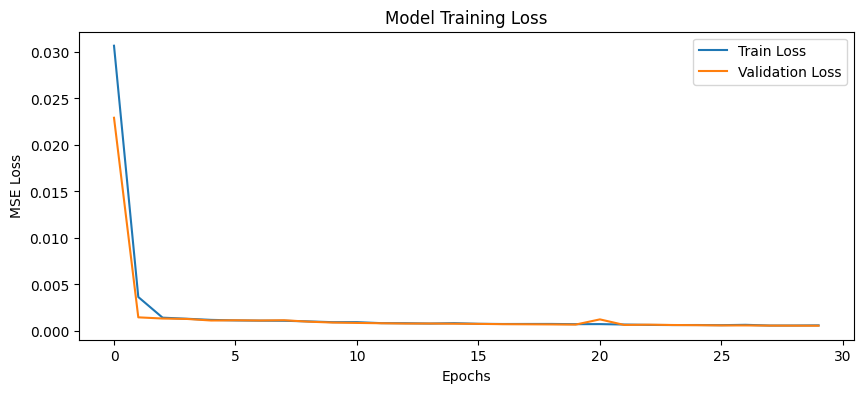

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


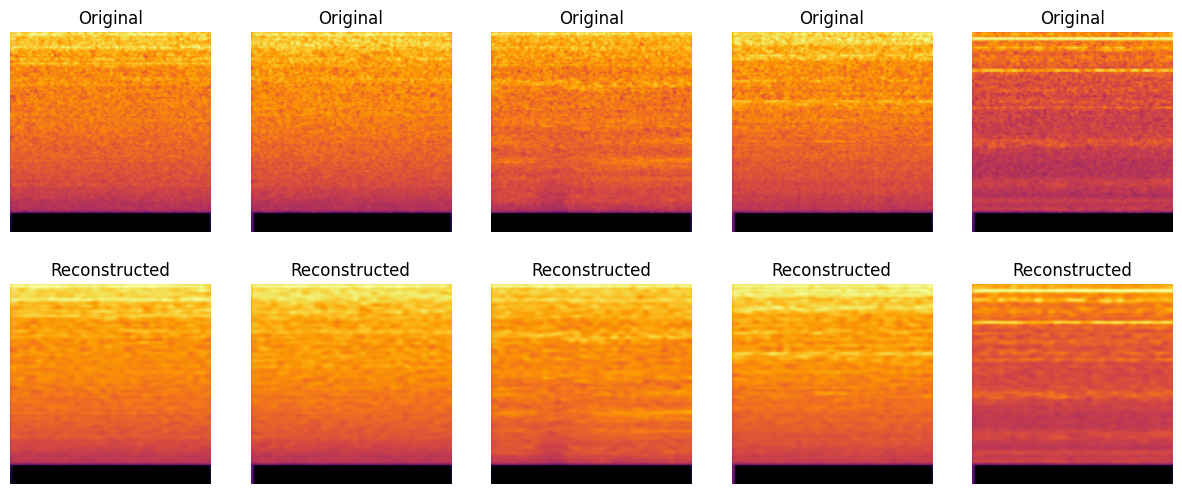

In [7]:
# 1. Plot Training Loss 
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

# 2. Check Reconstructions

# Predict on the first 5 images
decoded_imgs = model.predict(X_train[:5])

# Original vs Reconstructed
n = 5
plt.figure(figsize=(15, 6))
for i in range(n):
    # Original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_train[i].reshape(128, 128), cmap='inferno')
    plt.title("Original")
    plt.axis('off')

    # Reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(128, 128), cmap='inferno')
    plt.title("Reconstructed")
    plt.axis('off')
plt.show()

## Conclusion 
The Autoencoder has successfully learned the normal motor patterns, because:

1. Quantitative Evidence (Loss Curve): The training loss decreased significantly over the epochs and flattened out. This shows the model has reached a stable state where it can compress the audio data into the latent space and decompress it with minimal mathematical error (MSE).

2. Qualitative Evidence (Visual Reconstruction): The reconstructed spectrograms  resemble the original inputs. While they may appear slightly blurrier (which is normal for Autoencoders due to compression), the key structural features, such as the frequency bands and time patterns, are preserved.

## 5. Establish the "Normal" Error Threshold
- calculate the baseline error
- How much error is normal for a healthy motor?

95/95 ━━━━━━━━━━━━━━━━━━━━ 16s 170ms/step


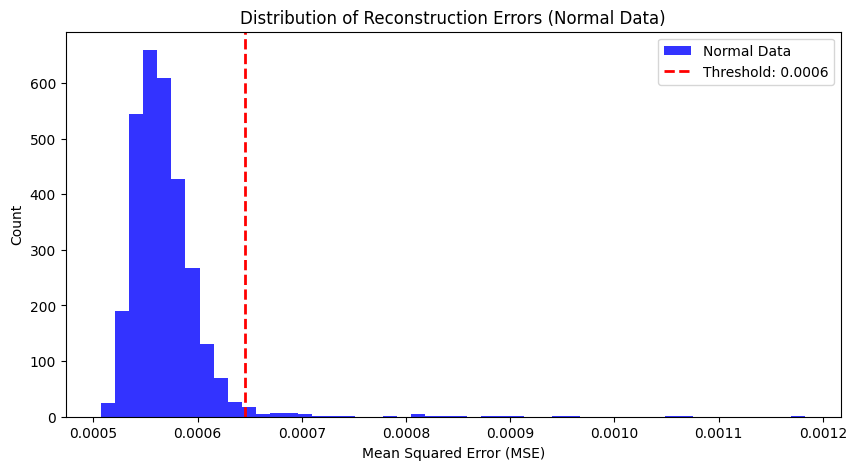

 Suggested Threshold for Part B: 0.00065
 (Anything with error > 0.00065 will be an anomaly)


In [10]:
# 1. Calculate MSE for every single image in X_train
reconstructions = model.predict(X_train)
train_loss = tf.keras.losses.mse(reconstructions, X_train)

# 2. Average over pixels (to get one score per image)
train_loss = np.mean(train_loss, axis=(1, 2))

# 3. plot
plt.figure(figsize=(10, 5))
plt.hist(train_loss, bins=50, alpha=0.8, color='blue', label='Normal Data')
plt.title("Distribution of Reconstruction Errors (Normal Data)")
plt.xlabel("Mean Squared Error (MSE)")
plt.ylabel("Count")

# 4. threshold (Mean + 2*StdDev)
threshold = np.mean(train_loss) + 2 * np.std(train_loss)
plt.axvline(threshold, color='red', linestyle='dashed', linewidth=2, label=f'Threshold: {threshold:.4f}')
plt.legend()
plt.show()

print(f" Suggested Threshold for Part B: {threshold:.5f}")
print(f" (Anything with error > {threshold:.5f} will be an anomaly)")

choosing Mean + 2*StdDev, we cover about 95% of the normal data.
- Risk: We might accidentally flag 5% of healthy motors as false positives.
- Benefit: We make the system sensitive enough to catch subtle defects.

# 7. Process the Anomaly Data (Broken Motors)
- Since we only loaded the normal data so far with prerpocessing.py, we need to load the anomaly data now so we can test the model against it

In [11]:
import librosa
import os

# Function to process audio exactly like we did in preprocessing.py
def load_and_process_anomaly(path):
    files = [f for f in os.listdir(path) if f.endswith('.wav')]
    X_data = []
    
    print(f"Processing {len(files)} anomaly files from {path}...")
    
    for file in files:
        # 1. Load Audio (3 seconds)
        file_path = os.path.join(path, file)
        try:
            y, sr = librosa.load(file_path, sr=None, duration=3.0)
            
            # 2. Spectrogram
            mel_spect = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
            mel_spect = librosa.power_to_db(mel_spect, ref=np.max)
            
            # 3. Resize to 128x128
            if mel_spect.shape[1] < 128:
                mel_spect = np.pad(mel_spect, ((0, 0), (0, 128 - mel_spect.shape[1])))
            else:
                mel_spect = mel_spect[:, :128]
                
            # 4. Normalize (0 to 1)
            mel_spect = (mel_spect - mel_spect.min()) / (mel_spect.max() - mel_spect.min())
            
            X_data.append(mel_spect)
        except Exception as e:
            print(f"Skipping broken file {file}: {e}")

    # Add channel dimension (N, 128, 128, 1)
    return np.array(X_data)[..., np.newaxis]

# --- ACTION ---
# Load the anomaly data
# NOTE: Ensure this path matches where you put the anomaly files
X_test_anomaly = load_and_process_anomaly('../data/raw/anomaly/')
print(f"Anomaly Data Loaded :D Shape: {X_test_anomaly.shape}")

Processing 300 anomaly files from ../data/raw/anomaly/...
Anomaly Data Loaded :D Shape: (300, 128, 128, 1)


## 8: Extract Encoder & Generate Features
- Now we slice your model in half. We keep only the encoder part.
- We push all our images (normal and anomaly) through it to get the latent Vectors (the compressed features).

In [12]:
# 1. Extract the Encoder
# take the input from the trained model and the output from the bottleneck layer (layer 3)
encoder = models.Model(inputs=model.input, outputs=model.layers[3].output)
print("Encoder extracted successfully :D")

# 2. Generate Features (latent vectors)
# This converts 128x128 --> 16x16x128 feature blocks
print("Generating features...")
latent_normal = encoder.predict(X_train, verbose=1)
latent_anomaly = encoder.predict(X_test_anomaly, verbose=1)

print(f"Feature Shapes:")
print(f" - Normal:  {latent_normal.shape}")
print(f" - Anomaly: {latent_anomaly.shape}")

Encoder extracted successfully :D
Generating features...
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Feature Shapes:
 - Normal:  (3009, 16, 16, 128)
 - Anomaly: (300, 16, 16, 128)


## 9. Save 
- save the features. Use these saved .npy files for Task B (Isolation Forest)

In [18]:
# Create directory just in case
os.makedirs('../data/processed', exist_ok=True)

# 1. Save the Latent Vectors (The Features)
np.save('../data/processed/latent_normal.npy', latent_normal)
np.save('../data/processed/latent_anomaly.npy', latent_anomaly)

# 2. Save the Encoder Model (The Tool)
encoder.save('../data/processed/encoder_model.h5')

print("Files saved:")
print("1. ../data/processed/latent_normal.npy")
print("2. ../data/processed/latent_anomaly.npy")
print("3. ../data/processed/encoder_model.h5")

Files saved:
1. ../data/processed/latent_normal.npy
2. ../data/processed/latent_anomaly.npy
3. ../data/processed/encoder_model.h5
